# 1. Specify the system type

In [1]:
import warnings
warnings.filterwarnings("ignore")

# specify the system
from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Fusion_system'
which_system(plasma_system)

from RBG_Maxwell.Collision_database.Fusion_system.collision_type import collision_type_for_all_species

# 2. Specify the coefficient for unit conversion 

In [2]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [3]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
dx = dy = 10**(-5)
dz = 10**(-5)

# velocity
v_max = 5*1.87683*10**6

# charge
Q = 1.6*10**(-19) 

# maximum momentum
momentum = 10**(-30)*v_max

# the momentum grid is set to be 
# half_px=half_pz=half_py=momentum
npy=npz=201
npx=1
dpz = dpy = 2*momentum/npy
dpx = 2*momentum
dp_volume = dpx*dpy*dpz
dp = (dpy+dpz)/2

# time scale
dt = 10**(-13)

# number of maximum particles in each phase grid
n_max = 5*10**(-15)/(1.6*10**(-19))/(npx*npy*npz)

# number of averaged particles in each spatial grid
nx = 1
ny = nz = 101
n_average = 5*10**(-15)/(1.6*10**(-19))/(nx*ny*nz)


E = 10**5
B = 10**(-5)

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx*dy*dz, dp, dp_volume,\
                                                                       n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [5]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma

In [6]:
# time step, and spatial infinitesimals
# dt is 10**(-13) s, dx = dy = dz = 10**(-5) m
dt, dx, dy, dz = dt*conversion_table['second'], \
                 dx*conversion_table['meter'], \
                 dy*conversion_table['meter'], \
                 dz*conversion_table['meter']

# we have only one type of particle e-
num_particle_species = 1

# treat the electron as classical particles
particle_type = np.array([0])

# masses, charges and degenericies are
masses, charges, degeneracy = np.array([9.11*10**(-31)*conversion_table['kilogram']]), \
                              np.array([-1.6*10**(-19)*conversion_table['Coulomb']]),\
                              np.array([1.])

# momentum grids
npx, npy, npz = npx, npy, npz

# half_px, half_py, half_pz
# momentum range for x and z direction are not import in this case
half_px, half_py, half_pz = np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]), \
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]),\
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']])

dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz

# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [7]:
# number of spatial grids
# must be integers and lists
# odd numbers are recomended
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [nx], [ny], [nz]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-nx/2*dx],\
                                                 [-ny/2*dy],\
                                                 [-nz/2*dz]

# number samples gives the number of sample points in MC integration
num_samples = 100

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 1


# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)

# 5. Specify the initial and boundary condition for plasma evolution

In [8]:
import math
v_collect = np.zeros([npx,npy,npz])
for ipx in range(npx):
    px = dpx[0]*(ipx+0.5) - half_px[0]
    for ipy in range(npy):
        py = dpy[0]*(ipy+0.5) - half_py[0]
        for ipz in range(npz):
            pz = dpz[0]*(ipz+0.5) - half_pz[0]
            # current velocity
            pnorm = math.sqrt((px**2+py**2+pz**2))
            Enorm = math.sqrt(px**2+py**2+pz**2+masses[0]**2*c**2)
            v = pnorm/Enorm
            v_collect[ipx, ipy, ipz] = v
v_average = masses[0]*\
            1.87683*10**6*conversion_table['meter']/conversion_table['second']*\
            1/math.sqrt(1-(1.87683*10**6/c)**2)

In [9]:
sigma = 0.2*v_average
mu = v_average
p_v = 1/math.sqrt(2*math.pi*sigma**2)*np.exp(-(np.array(v_collect-v_average))**2/(2*sigma**2))
p_v = p_v/p_v.sum()*5*10**(-15)/(1.6*10**(-19))

In [10]:
import ray
ray.shutdown()
ray.init()

2024-05-15 23:01:01,005	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8270 


Python version:,3.7.13
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8270


In [11]:

def f(x):
    return x + 1

plasma_single_GPU = (ray.remote(num_gpus = num_gpus_for_each_region))(f)


In [12]:

num_momentum_levels = 1

# iniital distribution function
f = {}
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx, npy, npz])

# the momentum distribution is a Gaussian function
phase_space_volume = dx*dy*dz*dpx*dpy*dpz
for ipx in range(npx):
    for ipy in range(npy):
        for ipz in range(npz):
            # current velocity
            f[0][0][0][0,51,51,ipx,ipy,ipz] = p_v[ipx,ipy,ipz]


# reshape the distribution function in different regions
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx*npy*npz])

'''
We add an external magnetic field of 10 T in the +y direction
'''
# BBy = [10*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BEx, BEy, BEz, BBx, BBy, BBz = [0],[0],[0],[0],[0],[0]

plasma = Plasma(f, dt, \
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                npx, npy, npz, half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0, \
                num_samples = 100, drift_order = 2,\
                rho_J_method="raw", GPU_ids_for_each_region = ["2"])

[100]


### Check if the initial velocity distribution is correct

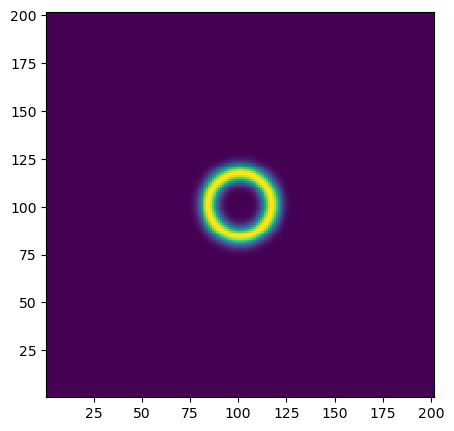

In [13]:
fff=f[0].reshape([num_momentum_levels, num_particle_species,\
                  nx_o[0],ny_o[0],nz_o[0],npx,npy,npz])[0,0,0,51,51,0]
# spatial distribution
import matplotlib.pyplot as plt

xi, yi = np.mgrid[1:202:1,1:202:1]
fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (5,5))
axes.pcolormesh(xi, yi, fff)

# 6. Perform evolution

In [14]:
n_step = 5001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
import time
start_time = time.time()
for i_time in range(n_step):  
    
    # if i_time%1000 == 0:
    #     dis.append(plasma.acquire_values("Distribution"))            
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':0., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)
    if i_time%500 == 0:     
        print('Updating the {}-th time step'.format(i_time))
        number_rho.append(plasma.acquire_values("number_rho/J"))
#         charged_rho.append(plasma.acquire_values("Electric rho/J"))
#     EM.append(plasma.acquire_values('EM fields on current region'))
end_time = time.time()

(Plasma_single_GPU pid=2694681) Using context GPU-664076ee-e781-2b13-0c9d-55cb6696c522 for region 0.
Updating the 0-th time step
Updating the 500-th time step
Updating the 1000-th time step
Updating the 1500-th time step
Updating the 2000-th time step
Updating the 2500-th time step
Updating the 3000-th time step
Updating the 3500-th time step
Updating the 4000-th time step
Updating the 4500-th time step
Updating the 5000-th time step


In [17]:
end_time-start_time

1202.4791011810303

# 7. Results

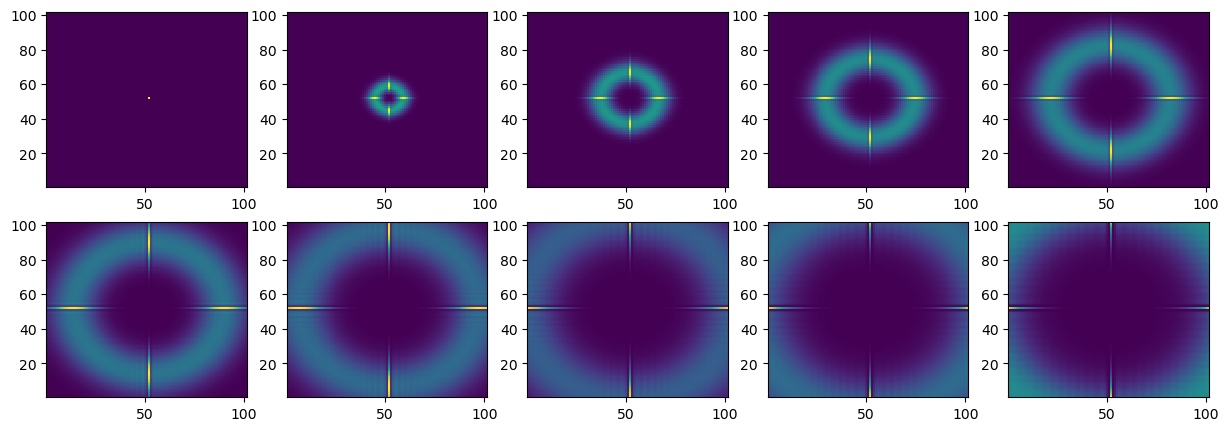

In [18]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:102:1,1:102:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk)][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])

# save data

In [14]:
for ii in [50,80,210]:
    Ey = [EM[i][0][1]*conversion_table_reverse['TO_Volt/m'] for i in range(0,10000,100)]
    Ey = [Ey[i].reshape([nx_o[0],ny_o[0],nz_o[0]])[0,ii,55] for i in range(100)]
    x = np.linspace(0,100,num=100)*dt*conversion_table_reverse['TO_second']*100*10**9
    # data in point pair
    np.savetxt('Ey@'+str(ii)+'.txt',np.transpose(Ey).flatten())
xi, yi = np.mgrid[1:252:1,1:112:1]
for i in range(11):
    # data in point pairs
    num_save = np.transpose([number_rho[i][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0]/conversion_table_reverse['TO_meter']**3])
    np.savetxt('number density@'+str(i)+'.txt',num_save.flatten())

In [51]:
np.array(number_rho[0][0][0]).reshape([nx_o[0],ny_o[0],nz_o[0]])[0].shape

(251, 111)